# Exploratory data analysis

## Goal for this notebook: data manipulation and cleaning. 

In [1]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy as np

In [2]:
peloton = pd.read_csv("./data/data.csv", header = None)

In [3]:
peloton.columns = ['user_A', "user_B","event_time"]

### A quick look at the first few lines of the data.

In [4]:
peloton.head()

,user_A,user_B,event_time
0,c8501e4e-7914-411b-9d0c-96a3180d0daa,4380277a-5cb8-42d7-8b21-2a7daba6906f,1516901020
1,1b906005-3fc7-44df-a93f-cc7afdf11bd4,6427b7f4-9223-4bfb-8d9b-e19abeeb387e,1516901488
2,c8270f60-5ce2-4df0-9487-eb6fd1ca2369,36cbbb08-5794-43f2-92d1-c6313ac355f8,1516901074
3,5d1a38a1-39ce-4640-8c3c-bb010e9a64ab,329d3d52-ce78-4d3a-8a91-f765a31e0319,1514410055
4,82f959c6-559d-4d51-8323-0c41a0741f4a,de77a7b7-b2af-4738-9d3b-4948d23f0f57,1514410067


In [5]:
peloton.shape

(465930, 3)

### Check for missing data: no missing data

In [6]:
peloton.isna().sum()

user_A        0
user_B        0
event_time    0
dtype: int64

### Check for duplicate data: no duplicated data.

In [7]:
peloton[['user_A',"user_B"]].duplicated().sum()

0

### Check for distribution of the event_time.

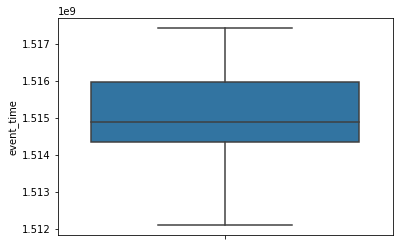

In [8]:
sns.boxplot(y = "event_time",data = peloton)

There is no outlier in the event_time data.

In [9]:
pd.to_datetime(peloton['event_time'], unit = "s").max()

Timestamp('2018-01-31 23:59:51')

In [10]:
pd.to_datetime(peloton['event_time'], unit = "s").min()

Timestamp('2017-12-01 00:00:01')

### The data contains the events from 2017-12-01 to 2018-01-31. 

## Determine the control vs experiment group.

A subset of users received a push notification to the iOS app
notifying them of any new follower. 

1. Users with an id that starts with one of “b”, “c”, “e”, “f”, “5” received the push notification. (Call this notification group)
2. Everyone else did not receive a notification and had no other change in their experience. (Call this no notification group)

There are a total of four outcomes:
> 1. A -> B (notification), then B -> A (notification or no notification)  : **Experiment group**
> 2. A -> B (notification), then B-/> A (B did not follow back A) : **Experiment group**
> 3. A -> B (no notification), then B -> A (notification or no notification)  : **control group**
> 4. A -> B (no notification), then B-/> A (B did not follow back A) : **control group**

A new dataframe will be created for conducting hypothesis testing.

The new dataframe contains four columns: `user_A, user_B, event_start (user_A follows user_B), event_end (user_B follows back)`. 

In this dataframe, it is created in this way that user_A follows user_B before user_B follows user_A. 

After those four columns are created, the experiment/control group `assignment` column can be created easily.

Then, the amount of time for a mutual connection to form can also be created easily with `event_start` and `event_end` columns. 

## Reformat the dataset for analytics

The dataset is not fit for analytics in current format. 

The reformatted dataset contains five columns:

`user_A`: str. The person who follows user_B first.

`user_B`: str. the Person who was folloed by user_A first. 

`event_start`: float. the time when user_A follows user_B. Since user_A is the person who follows user_B first, event_start column is always smaller than event_end column.

`event_end`: float.  the time when user_B follows user_A. This is the time when a mutual relationship between user_a and user_B is formed. 

`assignment`: str. "Experiment" or "Control". If the formation of the mutual relationship is considered to be in the experiment or control group. 

> Given the dataset and the row number of the dataset, `check_follow_back` function will find if user_B follows user_A. If user_B also follows user_A, the first person who follows the other is assigned to be in user_A column, while the second person is assigned to be in user_B column. The event_start and event_end time is also assigned accordingly. The second instance where the follow-event happens is assigned all NA values. If user_A and user_B follow each other in the same second, the event_start column will be NA values. 

In [11]:
# this function find the matching pair of user_A and user_B then updates the dataset. 
def check_follow_back(data,index,user_A_values, user_B_values):

    # get the user_A and user_B values.
    user_A = user_A_values[index]
    user_B = user_B_values[index]
    
    # find the index where user_A follows user_B
    # find the index where user_B follows user_A
    user_A_follow_index = (user_A_values == user_B)
    user_B_follow_index = (user_B_values == user_A)
    
    # check if user_B follows back user_A.
    if data[user_A_follow_index & user_B_follow_index].shape[0] == 1:
        # get the event-time for when user_A and user_B follows one another. 
        user_A_event_time = data['event_time'][index]
        user_B_index = data[user_A_follow_index & user_B_follow_index].index.values[0]
        user_B_event_time = data['event_time'][user_B_index]
        print(user_B_index)

        if user_A_event_time < user_B_event_time:
            data.iloc[index] = [user_A, user_B, user_A_event_time, \
                                user_A_event_time, user_B_event_time ]
            
            data.iloc[user_B_index] = [np.nan, np.nan, np.nan,\
                                   np.nan, np.nan ]
            
            
        elif user_B_event_time < user_A_event_time:
            data.iloc[index] = [user_B, user_A, user_A_event_time,\
                               user_B_event_time, user_A_event_time]
            
            data.iloc[user_B_index] = [np.nan, np.nan, np.nan,\
                                   np.nan, np.nan ]
    else:
        data.loc[data.index[index], "event_start"] \
        = data.loc[data.index[index], "event_time"]
                    
    return data
            
    

In [12]:
analytics_data = peloton.copy()

analytics_data["event_start"] = np.nan
analytics_data['event_end'] = np.nan

entire_user_A = analytics_data['user_A'].copy().values
entire_user_B = analytics_data['user_B'].copy().values

In [13]:
analytics_data = check_follow_back(analytics_data,0, \
                                   user_A_values = entire_user_A,
                                  user_B_values = entire_user_B)
print(analytics_data.iloc[0].values)

print(analytics_data.iloc[932].values)

932
['c8501e4e-7914-411b-9d0c-96a3180d0daa'
 '4380277a-5cb8-42d7-8b21-2a7daba6906f' 1516901020.0 1516901020.0
 1516907271.0]
[nan nan nan nan nan]


The above is one example of the outcome of the `check_follow_back` function. If we iterate through all the rows, then the dataset is ready for analytics. 


All the computation was actually done by the `analytics_data.py` file in the `data` directory. 


## Read in reformatted analytics data. 

In [14]:
analytics_data_final = pd.read_csv("./data/analytics_data.csv")

analytics_data_final.head()

,user_A,user_B,event_time,event_start,event_end
0,c8501e4e-7914-411b-9d0c-96a3180d0daa,4380277a-5cb8-42d7-8b21-2a7daba6906f,1.516901e+09,1.516901e+09,1.516907e+09
1,1b906005-3fc7-44df-a93f-cc7afdf11bd4,6427b7f4-9223-4bfb-8d9b-e19abeeb387e,1.516901e+09,1.516901e+09,NaN
2,36cbbb08-5794-43f2-92d1-c6313ac355f8,c8270f60-5ce2-4df0-9487-eb6fd1ca2369,1.516901e+09,1.516814e+09,1.516901e+09
3,329d3d52-ce78-4d3a-8a91-f765a31e0319,5d1a38a1-39ce-4640-8c3c-bb010e9a64ab,1.514410e+09,1.514399e+09,1.514410e+09
4,82f959c6-559d-4d51-8323-0c41a0741f4a,de77a7b7-b2af-4738-9d3b-4948d23f0f57,1.514410e+09,1.514410e+09,1.514739e+09


Check the missing value amount. 

In [15]:
analytics_data_final.isna().sum()

user_A         153125
user_B         153125
event_time     153125
event_start    153137
event_end      312805
dtype: int64

Get rid of the rows that contains missing values in user_A column. 

In [16]:
keep_index = analytics_data_final['user_A'].notna()

In [17]:
analytics_data_final = analytics_data_final.copy().loc[keep_index]

In [18]:
analytics_data_final.reset_index(drop = True, inplace = True)

Check for missing values again.

In [19]:
analytics_data_final.isna().sum()

user_A              0
user_B              0
event_time          0
event_start        12
event_end      159680
dtype: int64

The missing value in event_start is due to the fact that user_A and user_B follows each other in the same second.

We will discord those 12 records since it is not possible to determine the following order. 

In [20]:
analytics_data_final[analytics_data_final['event_start'].isna()].values

array([['fa2995da-6794-4309-805a-1be5831bb240',
        '88bb01ba-09e8-4769-b6aa-1d874f57f53d', 1512307813.0, nan, nan],
       ['88bb01ba-09e8-4769-b6aa-1d874f57f53d',
        'fa2995da-6794-4309-805a-1be5831bb240', 1512307813.0, nan, nan],
       ['353694ce-457b-420a-a659-4dd87a8ff4a8',
        '94851109-4627-4aac-9803-24a8de59bc2d', 1514352619.0, nan, nan],
       ['94851109-4627-4aac-9803-24a8de59bc2d',
        '353694ce-457b-420a-a659-4dd87a8ff4a8', 1514352619.0, nan, nan],
       ['fefc30e9-29a1-414a-810f-5b4ca8fbe174',
        'a1617b20-6551-4694-9ab6-696ed5039e1b', 1515293869.0, nan, nan],
       ['a1617b20-6551-4694-9ab6-696ed5039e1b',
        'fefc30e9-29a1-414a-810f-5b4ca8fbe174', 1515293869.0, nan, nan],
       ['4e4f46d4-13d6-43e9-aba9-bb85c67170e2',
        '28bcf77e-fa68-4901-8ba3-4f942fdc0006', 1513298087.0, nan, nan],
       ['28bcf77e-fa68-4901-8ba3-4f942fdc0006',
        '4e4f46d4-13d6-43e9-aba9-bb85c67170e2', 1513298087.0, nan, nan],
       ['d7fa1c30-6885-4f81-ad9a

In [21]:
analytics_data_final = analytics_data_final[analytics_data_final['event_start'].notna()].copy()

In [22]:
analytics_data_final.reset_index(drop = True, inplace = True)

### A function to determine whether a specific user is in Control or Experiment group. 

In [23]:
def assign_experiment(user_id):
    char_list = ("b","c","e","f","5")
    char = user_id[0]
    if char in char_list:
        result = "Experiment"
    elif char not in char_list:
        result = "Control"
    return result

In [24]:
analytics_data_final['assignment'] = analytics_data_final['user_B'].apply(assign_experiment) 

Since user_B is the first one being followed, we should apply the above function to the column user_B

In [25]:
analytics_data_final.drop("event_time", axis = 1, inplace = True)

In [26]:
analytics_data_final.to_csv("./data/clean_analytics.csv", index = False)

## Final notes for data cleaning and manipulation:
1. I do not have the data for push notification happening, if I do I would double check that.
2. Does using the first letter of the hashed user_id truly a truly random assignment process? I can not determine that since I do not know how the user_id is hashed. 